# Student Information

* Name : Sandikha Rahardi
* Group : РИМ-130908

# Lab assignment for the "Classification" module

The goal of this lesson is to develop a model that predicts the class of a message: "spam" or "not-spam"

In this lesson, we will receive the initial dataset, look at the data, do some preprocessing, and then try to apply a self-written K-nearest neighbors model to it

# About Dataset

https://www.kaggle.com/datasets/prishasawhney/email-classification-ham-spam

The Email Classification dataset has been synthetically generated. This meticulously curated dataset is designed to enhance your natural language processing prowess. It comprises 2 columns.

* Email: This column contains the textual description of the email/ message, offering a diverse range of vocabulary and language patterns.
* Label: Each review is classified into either Ham (non-spam) or Spam.

You can use this dataset to fine-tune existing pre-trained Large Language Models, create your own NLP models, and perform tasks of text-classification using techniques such as Logistic Regression, Naive Bayes, Recursive Neural Network (RNN), and various other methods to hone your NLP skills.

Useful Tip: For better use, you can map the label column to numeric values. You can also create N-gram models and tables for the same to analyze the dataset better.

# Import Libraries

In [1]:
import nltk
import spacy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

nltk.download('stopwords')

from nltk.stem import PorterStemmer
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kuldii/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 1.7 MB/s eta 0:00:0000:0100:01m

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [3]:
df = pd.read_csv("data/email_classification.csv")
df.head()

,email,label
0,Upgrade to our premium plan for exclusive acce...,ham
1,Happy holidays from our team! Wishing you joy ...,ham
2,We're hiring! Check out our career opportuniti...,ham
3,Your Amazon account has been locked. Click her...,spam
4,Your opinion matters! Take our survey and help...,ham


# Data preprocessing

## Data Evaluation

Let's see how much data we have.

In [4]:
df.shape

(179, 2)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179 entries, 0 to 178
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   email   179 non-null    object
 1   label   179 non-null    object
dtypes: object(2)
memory usage: 2.9+ KB


In [6]:
df.isnull().sum()

email    0
label    0
dtype: int64

In [7]:
df["label"].value_counts()

label
ham     100
spam     79
Name: count, dtype: int64

## Creating Features

The original data was the message text. Is it a lot or a little? Enough. But let's try to add more data that will help us separate regular messages from advertising ones - for example, let's see how the length of text messages is distributed in each category

In [8]:
df['length'] = df['email'].apply(len)

In [9]:
df.head()

,email,label,length
0,Upgrade to our premium plan for exclusive acce...,ham,81
1,Happy holidays from our team! Wishing you joy ...,ham,73
2,We're hiring! Check out our career opportuniti...,ham,75
3,Your Amazon account has been locked. Click her...,spam,83
4,Your opinion matters! Take our survey and help...,ham,74


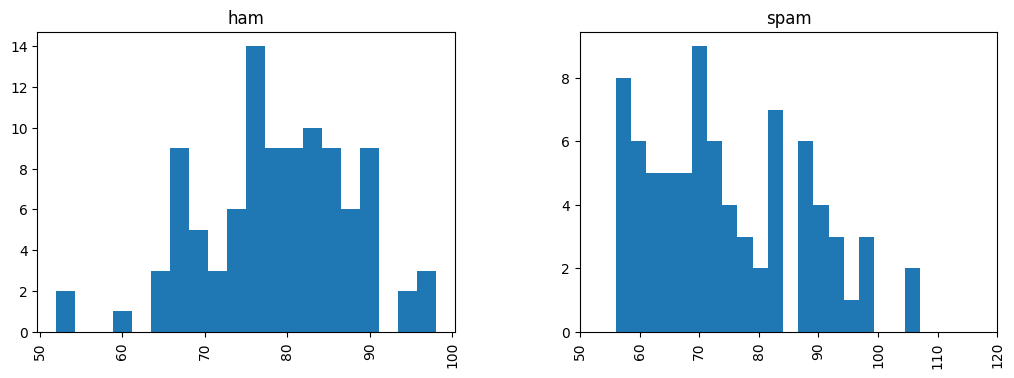

In [10]:
df.hist(column='length',by='label',bins=20,figsize=(12,4)); # histogram generation
plt.xlim(50,120); # histogram limitation (so that both graphs are on the same scale)

It can be seen that although length is not a dividing feature, useful information can be obtained from it.

## Encoding of names in one-hot

For ease of use of the model in the future, we will replace the text names of classes with numbers in the form of a unitary code. Its peculiarity is that the number contains only one unit, the location of which determines the class of the object

In [11]:
df['spam'] = df['label'].map({'ham': 0, 'spam': 1})
df.head()

,email,label,length,spam
0,Upgrade to our premium plan for exclusive acce...,ham,81,0
1,Happy holidays from our team! Wishing you joy ...,ham,73,0
2,We're hiring! Check out our career opportuniti...,ham,75,0
3,Your Amazon account has been locked. Click her...,spam,83,1
4,Your opinion matters! Take our survey and help...,ham,74,0


In [12]:
df.drop('label', axis=1, inplace=True) # and now we will delete the extra column with the original names

In [13]:
df.head()

,email,length,spam
0,Upgrade to our premium plan for exclusive acce...,81,0
1,Happy holidays from our team! Wishing you joy ...,73,0
2,We're hiring! Check out our career opportuniti...,75,0
3,Your Amazon account has been locked. Click her...,83,1
4,Your opinion matters! Take our survey and help...,74,0


## Clearing Text Data

The text contains a lot of information that will only interfere with classification. Let's clean it up. To figure out how to do this, we'll use regular expressions to remove some unnecessary characters, such as:
* email addresses
* web addresses
* numbers
* currency symbols
* punctuation marks

Original text (before processing)

In [14]:
print(df['email'])

0      Upgrade to our premium plan for exclusive acce...
1      Happy holidays from our team! Wishing you joy ...
2      We're hiring! Check out our career opportuniti...
3      Your Amazon account has been locked. Click her...
4      Your opinion matters! Take our survey and help...
                             ...                        
174    We're pleased to inform you that your refund h...
175    Get rich quick! Invest in our revolutionary ne...
176    Your free trial period is ending soon. Upgrade...
177    Your order is on its way! Track your shipment ...
178    Limited-time offer! Get 50% off on all purchas...
Name: email, Length: 179, dtype: object


In [15]:
# Replacing email addresses with the word 'email'
processed = df['email'].str.replace(r'^.+@[^\.].*\.[a-z]{2,}$', 'email')

# Replacing web addresses with the word 'webaddress'
processed = processed.str.replace(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$', 'webaddress')

# Replacing currency symbols with the word 'moneysymb' (The "£" symbol can be typed using Alt and the code 0163)
processed = processed.str.replace(r'£|\$', 'moneysymb')

# Replacing 10-digit phone numbers with the word 'phonenumber' (including special characters)
processed = processed.str.replace(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$', 'phonenumbr')

# Replacing other numbers with the word 'numbr'
processed = processed.str.replace(r'\d+(\.\d+)?', 'numbr')

# Removing punctuation marks
processed = processed.str.replace(r'[^\w\d\s]', ' ')

# Removing extra spaces (replacing several consecutive spaces with one)
processed = processed.str.replace(r'\s+', ' ')

# Removing spaces at the beginning and at the end
processed = processed.str.replace(r'^\s+|\s+?$', '')

# Converting characters to lowercase
processed = processed.str.lower()

# Now let's look at what we got
print(processed)

0      upgrade to our premium plan for exclusive acce...
1      happy holidays from our team! wishing you joy ...
2      we're hiring! check out our career opportuniti...
3      your amazon account has been locked. click her...
4      your opinion matters! take our survey and help...
                             ...                        
174    we're pleased to inform you that your refund h...
175    get rich quick! invest in our revolutionary ne...
176    your free trial period is ending soon. upgrade...
177    your order is on its way! track your shipment ...
178    limited-time offer! get 50% off on all purchas...
Name: email, Length: 179, dtype: object


You can also remove stop words. It is convenient to use the NLTK library for this

In [16]:
stop_words = set(nltk.corpus.stopwords.words('english'))

Let's look at some examples of stop words

In [17]:
list(stop_words)

["should've",
 'or',
 'me',
 'did',
 'the',
 'just',
 'ain',
 'been',
 'by',
 'will',
 'some',
 'where',
 'against',
 'all',
 'll',
 'through',
 "didn't",
 'here',
 'an',
 'below',
 'ma',
 'at',
 'itself',
 'myself',
 'our',
 'into',
 'no',
 'these',
 'too',
 'won',
 "hasn't",
 'yourself',
 'ours',
 "aren't",
 'hasn',
 'mightn',
 'not',
 'he',
 'do',
 'such',
 "shouldn't",
 'how',
 'doesn',
 'once',
 'yourselves',
 'until',
 'on',
 'off',
 'them',
 'again',
 'your',
 'between',
 'to',
 'can',
 "couldn't",
 'd',
 'aren',
 'this',
 're',
 "she's",
 'haven',
 'needn',
 "won't",
 'they',
 'both',
 's',
 'whom',
 'shouldn',
 'and',
 'couldn',
 'isn',
 'above',
 'for',
 'why',
 'if',
 'up',
 'during',
 'when',
 'other',
 'her',
 'his',
 'under',
 "you'll",
 'himself',
 "shan't",
 'who',
 've',
 "needn't",
 'very',
 "you're",
 'after',
 "wouldn't",
 'themselves',
 "you'd",
 'should',
 'down',
 'out',
 'm',
 'she',
 'was',
 'while',
 'were',
 'has',
 'that',
 'most',
 'only',
 'own',
 'it',
 '

Remove all stop words from message text

In [18]:
processed = processed.apply(lambda x: ' '.join(term for term in x.split() if term not in stop_words))

In [19]:
print(processed)

0      upgrade premium plan exclusive access premium ...
1      happy holidays team! wishing joy prosperity se...
2      we're hiring! check career opportunities join ...
3      amazon account locked. click verify account in...
4      opinion matters! take survey help us enhance e...
                             ...                        
174    we're pleased inform refund processed successf...
175    get rich quick! invest revolutionary new schem...
176    free trial period ending soon. upgrade continu...
177         order way! track shipment real-time updates.
178    limited-time offer! get 50% purchases today on...
Name: email, Length: 179, dtype: object


There are still a lot of different words. Let's apply stemming - a method for finding the basis of words - in the hope that there will be fewer different words. For this, we will use a ready-made module - PorterStemmer from the already familiar NLTK library

In [20]:
ps = PorterStemmer()
processed_stem = processed.apply(lambda x: ' '.join(ps.stem(term) for term in x.split()))

In [21]:
print(processed_stem)

0      upgrad premium plan exclus access premium cont...
1           happi holiday team! wish joy prosper season.
2      we'r hiring! check career opportun join dynam ...
3      amazon account locked. click verifi account in...
4      opinion matters! take survey help us enhanc ex...
                             ...                        
174       we'r pleas inform refund process successfully.
175    get rich quick! invest revolutionari new schem...
176    free trial period end soon. upgrad continu enj...
177          order way! track shipment real-tim updates.
178    limited-tim offer! get 50% purchas today only....
Name: email, Length: 179, dtype: object


## Creating Features

There is a lot of data, and besides, it is categorical, and most ML models use only numerical characteristics. Therefore, we use the "Bag of words" approach, which will help extract numerical features from text data

For this, we will again use a ready-made module - Scikit learn, and with its help we will select the 1500 most frequently occurring words, for which we will make a markup

In [22]:
cv = CountVectorizer(max_features=1500) # 1500 words in the form of signs
X_cv = cv.fit_transform(processed_stem).toarray()

If you look at X, you can see that the number of samples has remained the same, but the features have become 1500 - these are the most popular words

In [23]:
X_cv.shape

(179, 444)

## Training and test datasets

We will divide the data into test and training parts, with the training part being 20%

In [24]:
# Divide our data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_cv, df["spam"], test_size=0.20, random_state=42)

In [25]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(143, 444) (36, 444) (143,) (36,)


# Creating a model

## Ready model from the library

In order to see how the finished model works, we use high-level functions

In [26]:
knn = KNeighborsClassifier(n_neighbors = 1) # initialize model (with given hyperparameters)
knn.fit(X_train, y_train.values.ravel()) # train on training data
pred_knn = knn.predict(X_test) # and finally predict test data

Let's see what happened with the prediction. We use standard metrics - accuracy, recall and F1-measure

In [27]:
print('Accuracy: {}% \n'.format(accuracy_score(y_test, pred_knn) * 100)) # number of correct predictions in %
print(confusion_matrix(y_test, pred_knn)) # matrix displaying errors of type 1 and type 2
print(classification_report(y_test, pred_knn))

Accuracy: 91.66666666666666% 

[[12  2]
 [ 1 21]]
              precision    recall  f1-score   support

           0       0.92      0.86      0.89        14
           1       0.91      0.95      0.93        22

    accuracy                           0.92        36
   macro avg       0.92      0.91      0.91        36
weighted avg       0.92      0.92      0.92        36



## Now we need to implement KNN ourselves...

For more details (and tips if needed), please see the links below or any other convenient source:
* https://realpython.com/knn-python/
* https://machinelearningmastery.com/tutorial-to-implement-k-nearest-neighbors-in-python-from-scratch/

In [28]:
class KNN(BaseEstimator, ClassifierMixin):
    """
    K-nearest neighbor classifier compatible with scikit-learn, supporting different distance metrics.
    """
    def __init__(self, k=1, distance_metric='euclidean'):
        self.k = k
        self.distance_metric = distance_metric

    def fit(self, X, y):
        """
        Fit the classifier on the training data.
        Arguments:
          X: np array (num_samples, num_features) - training data
          y: np array (num_samples,) - training labels
        """
        self.train_X = X
        self.train_y = y
        self.classes_ = np.unique(y)

    def predict(self, X):
        '''
        Predict the labels for the test data using the KNN classifier.
        Arguments:
          X: np array (num_samples, num_features) - data for prediction
        Returns:
          predictions: np array (num_samples,) - predicted classes for each sample in X
        '''
        dists = self.compute_distances(X)
        return self.predict_labels_binary(dists)

    def compute_distances(self, X):
        '''
        Calculate the distance between each test sample and each training sample.
        Supports both Euclidean and Manhattan distances.
        Arguments:
          X: np array (num_test_samples, num_features) - test samples
        Returns:
          dists: np array (num_test_samples, num_train_samples) - distances
          from each test sample to each training sample
        '''
        if self.distance_metric == 'euclidean':
            dists = np.sqrt(np.sum(X**2, axis=1, keepdims=True) +
                            np.sum(self.train_X**2, axis=1) -
                            2 * np.dot(X, self.train_X.T))
        elif self.distance_metric == 'manhattan':
            dists = np.abs(X[:, np.newaxis] - self.train_X).sum(axis=2)
        else:
            raise ValueError(f"Unsupported distance metric: {self.distance_metric}")
        return dists

    def predict_labels_binary(self, dists):
        '''
        Predict the label for each test sample based on the K-nearest neighbors.
        Arguments:
          dists: np array (num_test_samples, num_train_samples) - distances
          from each test sample to each training sample
        Returns:
          pred: np array (num_test_samples,) - predicted binary labels
        '''
        num_test = dists.shape[0]
        pred = np.zeros(num_test, dtype=int)

        for i in range(num_test):
            nearest_neighbors = np.argsort(dists[i])[:self.k]
            closest_y = self.train_y[nearest_neighbors]
            pred[i] = np.argmax(np.bincount(closest_y.astype(int)))

        return pred

    def get_params(self, deep=True):
        """
        Return parameters of the estimator for compatibility with GridSearchCV.
        """
        return {"k": self.k, "distance_metric": self.distance_metric}

    def set_params(self, **params):
        """
        Set parameters of the estimator for compatibility with GridSearchCV.
        """
        for key, value in params.items():
            setattr(self, key, value)
        return self


Now that the classifier is written, it can be trained.

In [29]:
knn_clf = KNN(k=1)
knn_clf.fit(X_train, y_train.values.ravel())

And make a prediction (this may take some time, so let's try it on a part of the dataset)

In [30]:
pred_clf = knn_clf.predict(X_test)

In [31]:
print('Accuracy: {}% \n'.format(accuracy_score(y_test, pred_clf) * 100))
print(confusion_matrix(y_test, pred_clf))
print(classification_report(y_test, pred_clf))

Accuracy: 91.66666666666666% 

[[12  2]
 [ 1 21]]
              precision    recall  f1-score   support

           0       0.92      0.86      0.89        14
           1       0.91      0.95      0.93        22

    accuracy                           0.92        36
   macro avg       0.92      0.91      0.91        36
weighted avg       0.92      0.92      0.92        36



## Tuning the classifier

What can be done to improve accuracy?

Experiment with the data - for example, add a feature "text message length" that was calculated but not used in training and prediction.
Explore a different set of hyperparameters or a different model architecture.

Try to improve the accuracy of your model

In [32]:
knn_classifier_with_params = KNN()

param_grid = {
    'k': [1, 3, 5, 7, 9, 11, 15, 20],
    'distance_metric': ['euclidean', 'manhattan']
}

grid_search = GridSearchCV(knn_classifier_with_params, param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train, y_train.values.ravel())

# Get the best hyperparameters and accuracy
print("Best parameters:", grid_search.best_params_)
print("Best cross-validated accuracy:", grid_search.best_score_)

Best parameters: {'distance_metric': 'manhattan', 'k': 7}
Best cross-validated accuracy: 0.8871921182266009


In [33]:
pred_modif = grid_search.predict(X_test)

In [34]:
print('Accuracy: {}% \n'.format(accuracy_score(y_test, pred_modif) * 100))
print(confusion_matrix(y_test, pred_modif))
print(classification_report(y_test, pred_modif))

Accuracy: 97.22222222222221% 

[[13  1]
 [ 0 22]]
              precision    recall  f1-score   support

           0       1.00      0.93      0.96        14
           1       0.96      1.00      0.98        22

    accuracy                           0.97        36
   macro avg       0.98      0.96      0.97        36
weighted avg       0.97      0.97      0.97        36



## Using Spacy

In [35]:
df

,email,length,spam
0,Upgrade to our premium plan for exclusive acce...,81,0
1,Happy holidays from our team! Wishing you joy ...,73,0
2,We're hiring! Check out our career opportuniti...,75,0
3,Your Amazon account has been locked. Click her...,83,1
4,Your opinion matters! Take our survey and help...,74,0
...,...,...,...
174,We're pleased to inform you that your refund h...,77,0
175,Get rich quick! Invest in our revolutionary ne...,72,1
176,Your free trial period is ending soon. Upgrade...,85,0
177,Your order is on its way! Track your shipment ...,68,0


In [36]:
nlp = spacy.load("en_core_web_sm")
stopwords = nlp.Defaults.stop_words
print(f'Spacy english stopwords size: {len(stopwords)}', end='\n\n')
' '.join(stopwords)

Spacy english stopwords size: 326



"fifteen did just will some all go seeming here used whoever thus whole nevertheless wherever yourself ours almost beside ‘re towards yourselves them between can moreover next re say seemed they and quite above for alone often if four never already up using his might whereupon n’t otherwise after becomes without she make was were except what a else but being rather forty its my their everyone than would over of 've whence yours fifty whatever although hers something are is n‘t does ‘d yet same three me whereafter by move an below indeed at whose itself no latterly amongst various upon not front such every eleven nowhere ‘m again off within around via ’re enough ‘ve afterwards whom meanwhile onto thereafter ’m name 'm really ‘s however should ’ve down while together beforehand ’s became only besides own it though then nobody per back done unless serious still before somehow us anyway mine whereby am seems as least side whenever i show see namely ’ll due six put in so now call twelve wel

In [37]:
%%time

df['cleaned_text'] = df['email'].apply(
    lambda x: ' '.join(
        token.lemma_.lower() for token in nlp(x) if
        not token.is_stop
        and not token.is_punct
        and not token.is_digit
        and not token.like_email
        and not token.like_num
        and not token.is_space
    )
)
df

CPU times: user 1.37 s, sys: 47.8 ms, total: 1.42 s
Wall time: 1.55 s


,email,length,spam,cleaned_text
0,Upgrade to our premium plan for exclusive acce...,81,0,upgrade premium plan exclusive access premium ...
1,Happy holidays from our team! Wishing you joy ...,73,0,happy holiday team wish joy prosperity season
2,We're hiring! Check out our career opportuniti...,75,0,hire check career opportunity join dynamic team
3,Your Amazon account has been locked. Click her...,83,1,amazon account lock click verify account infor...
4,Your opinion matters! Take our survey and help...,74,0,opinion matter survey help enhance experience
...,...,...,...,...
174,We're pleased to inform you that your refund h...,77,0,pleased inform refund process successfully
175,Get rich quick! Invest in our revolutionary ne...,72,1,rich quick invest revolutionary new scheme ret...
176,Your free trial period is ending soon. Upgrade...,85,0,free trial period end soon upgrade continue en...
177,Your order is on its way! Track your shipment ...,68,0,order way track shipment real time update


In [38]:
X_cv = cv.fit_transform(df['cleaned_text']).toarray()

In [39]:
X_cv.shape

(179, 372)

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X_cv, df["spam"], test_size=0.20, random_state=42)

In [41]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(143, 372) (36, 372) (143,) (36,)


In [42]:
knn_classifier_with_params = KNN()

param_grid = {
    'k': [1, 3, 5, 7, 9, 11, 15, 20],
    'distance_metric': ['euclidean', 'manhattan']
}

grid_search = GridSearchCV(knn_classifier_with_params, param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train, y_train.values.ravel())

# Get the best hyperparameters and accuracy
print("Best parameters:", grid_search.best_params_)
print("Best cross-validated accuracy:", grid_search.best_score_)

Best parameters: {'distance_metric': 'euclidean', 'k': 20}
Best cross-validated accuracy: 0.972167487684729


In [43]:
pred_modif = grid_search.predict(X_test)
print('Accuracy: {}% \n'.format(accuracy_score(y_test, pred_modif) * 100))
print(confusion_matrix(y_test, pred_modif))
print(classification_report(y_test, pred_modif))

Accuracy: 100.0% 

[[14  0]
 [ 0 22]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      1.00      1.00        22

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36

